In [29]:
#import lib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

#import model lib
from keras.layers import Dense, LSTM

#import model split
from sklearn.model_selection import train_test_split

In [30]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
None


In [31]:
#checking for null values
print(df.isna().any())

date            False
meantemp        False
humidity        False
wind_speed      False
meanpressure    False
dtype: bool


Text(0.5, 1.0, 'time against all atribute')

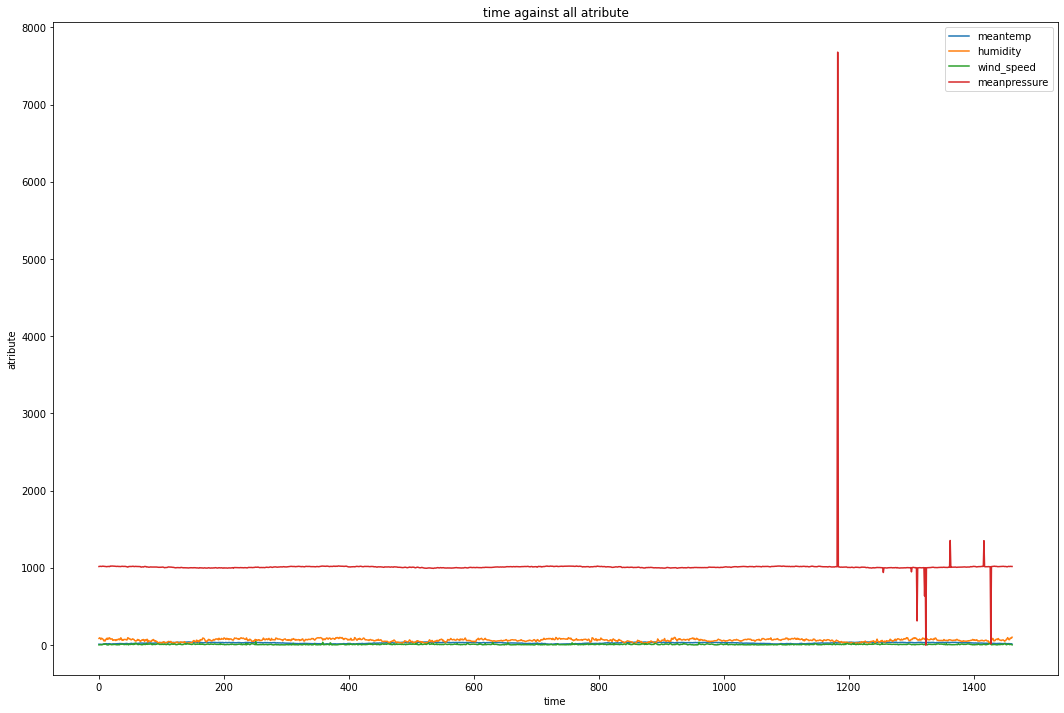

In [ ]:
df[['meantemp','humidity','wind_speed','meanpressure']].plot(figsize=(18,12))
plt.xlabel('time')
plt.ylabel('atribute')
plt.title('time against all atribute')

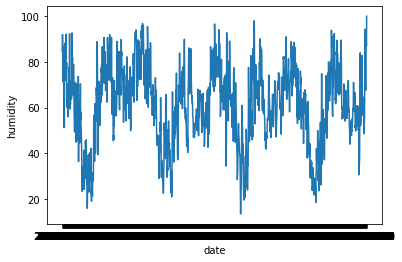

In [ ]:
sns.lineplot(data=df, x='date', y='humidity')

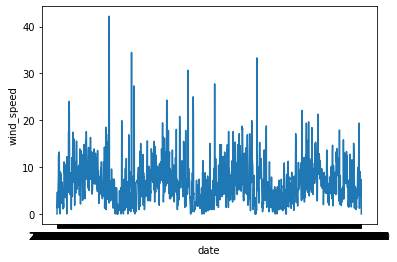

In [ ]:
sns.lineplot(data=df, x='date', y='wind_speed')

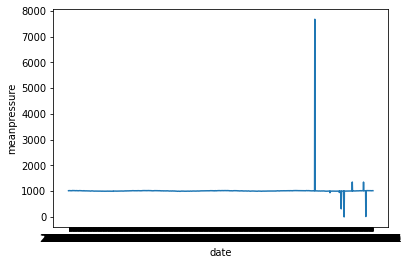

In [ ]:
sns.lineplot(data=df, x='date', y='meanpressure')

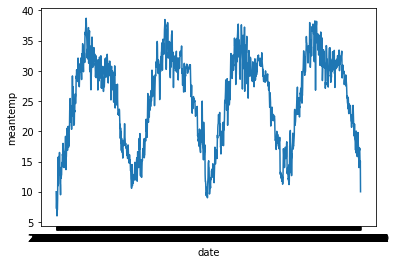

In [ ]:
sns.lineplot(data=df, x='date', y='meantemp')

In [32]:
train_size = math.ceil(len(df)*0.8) #train set 80% sehingga validation set menjadi 20%

train_df = df['meantemp'].iloc[:train_size]
test_df = df['meantemp'].iloc[train_size:]

len(train_df), len(test_df)

(1170, 292)

In [33]:
threshold = (df['meantemp'].max() - df['meantemp'].min()) * 10/100
threshold

3.2714285714285722

In [34]:
def data_prepare(X, y, window=60):
    xs,ys = [], []
    
    for i in range(len(X) - window):
        tmp = X.iloc[i: i+window].values
        xs.append(tmp)
        ys.append(y.iloc[i+window])
    
    return np.array(xs), np.array(ys)

X_train, y_train = data_prepare(train_df, train_df, 10)
X_test, y_test = data_prepare(test_df, test_df, 10)

In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, activation='relu', input_shape=(X_train.shape[1],1)),
    tf.keras.layers.Dense(30),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1),
])

In [36]:
opmz = tf.keras.optimizers.Adam(learning_rate=0.01)
callback = tf.keras.callbacks.ReduceLROnPlateau(patience=2,monitor='loss')

model.compile(loss=tf.keras.losses.mae,
              optimizer=opmz,
              metrics=["mae"]
)

history = model.fit(X_train, y_train, epochs=100, batch_size=10, callbacks=[callback])

Epoch 1/100
116/116 [==============================] - 4s 12ms/step - loss: 3.7807 - mae: 3.7807 - lr: 0.0100
Epoch 2/100
116/116 [==============================] - 1s 10ms/step - loss: 2.2577 - mae: 2.2577 - lr: 0.0100
Epoch 3/100
116/116 [==============================] - 1s 11ms/step - loss: 1.8334 - mae: 1.8334 - lr: 0.0100
Epoch 4/100
116/116 [==============================] - 1s 9ms/step - loss: 1.5122 - mae: 1.5122 - lr: 0.0100
Epoch 5/100
116/116 [==============================] - 2s 14ms/step - loss: 1.5115 - mae: 1.5115 - lr: 0.0100
Epoch 6/100
116/116 [==============================] - 1s 5ms/step - loss: 1.4118 - mae: 1.4118 - lr: 0.0100
Epoch 7/100
116/116 [==============================] - 1s 5ms/step - loss: 1.4617 - mae: 1.4617 - lr: 0.0100
Epoch 8/100
116/116 [==============================] - 1s 5ms/step - loss: 1.4565 - mae: 1.4565 - lr: 0.0100
Epoch 9/100
116/116 [==============================] - 1s 7ms/step - loss: 1.2111 - mae: 1.2111 - lr: 1.0000e-03
Epoch 10/10

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60)                14880     
                                                                 
 dense_6 (Dense)             (None, 30)                1830      
                                                                 
 dense_7 (Dense)             (None, 10)                310       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 17,031
Trainable params: 17,031
Non-trainable params: 0
_________________________________________________________________


In [38]:
print("train mae", history.history['mae'][-1])

train mae 1.1916214227676392


In [39]:
eval = model.evaluate(X_test,y_test)
print("testing mae", eval[1])

9/9 [==============================] - 0s 4ms/step - loss: 1.2131 - mae: 1.2131
testing mae 1.2130513191223145


pada hasil terlihat bahwa threshold yang ditentukan sebesar 3.271 dan model memiliki hasil training mae sebesar 1.191 dan testing mae sebesar 1.21 maka dengan itu MAE < threshold terpenuhi, dengan nilai 1.191 < 3.271 pada train dan pada testing 1.21 < 3.271

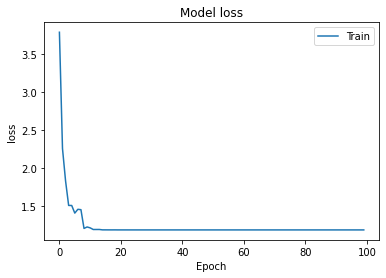

In [40]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

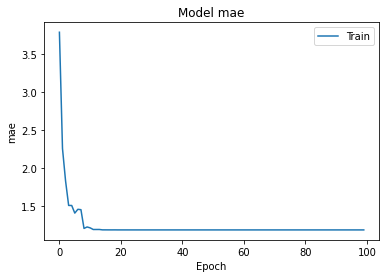

In [41]:
plt.plot(history.history['mae'])
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

Text(0.5, 1.0, 'Plotting Predicted And Actual Values')

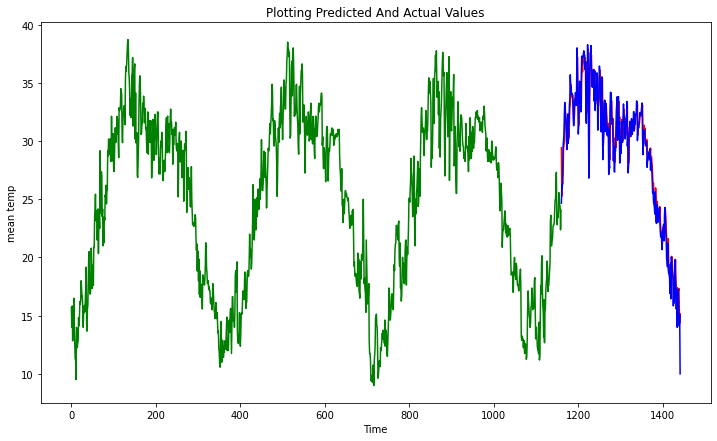

In [42]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(0, len(X_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), y_pred, 'r', label="predictions")
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), y_test, 'b', label="Actual")
plt.xlabel("Time")
plt.ylabel("mean temp")
plt.title("Plotting Predicted And Actual Values")